## Jeremy Kazimer
#### 5018-1732
#### Assignment #2

---

As always, import statements:

In [72]:
# NumPy
from numpy import array, linspace, zeros, argsort

# Matplotlib
from matplotlib import pyplot as plt

**(A.)** _Perturbation Potentials_

For this problem, we are given a quantum harmonic oscillator (QHO).  As such, it is important to consider that its potential takes on the form

\begin{equation}
V_0(x) = \dfrac{1}{2} m \omega^2 x^2
\end{equation}

where $m$ is the mass of the system, $\omega$ is the angular frequency of the system, and $x$ is the position of the system.  Normally, it would be important to distinguish for any vector $\vec{r}$, but we are focusing solely in the $x$ direction.  Reusing code from the `CompPhys` directory, we can create a QHO class named Schroedinger:

In [29]:
class Schroedinger : 

    def __init__(self, x_left, x_right, N) :
        
        # System properties
        self.hbar = 1.0                  # Planck's constant / 2pi
        self.m = 1.0                     # particle mass
        self.omega = 1.0                 # oscillator frequency
        self.E = 0.0                     # current energy in search
        
        # Graph properties
        self.N = N                       # number of lattice points = N+1
        self.x_left = x_left             # left boundary
        self.x_right = x_right           # right boundary
        self.h = (self.x_right - self.x_left) / self.N  # grid spacing
        self.xvals = linspace(self.x_left, self.x_right, self.N+1) # x value for phi
        
        # Functions
        self.phi_left = zeros(self.N+1)  # wave function integrating from left
        self.phi_right = zeros(self.N+1) # wave function integrating from right
        self.phi = zeros(self.N+1)       # whole wave function
        self.i_match = 0                 # Index of turning point
        self.x_match = 0.                # Turning point x value 
        self.sign = 1                    # current sign used to make F(E) continuous
        self.nodes = 0                   # current number of nodes in wavefunction

    def V(self, x):                   # harmonic oscillator potential
        return 0.5 * self.m * self.omega**2 * x**2

    def q(self, x):                   # Sturm-Liouville q function
        return 2 * self.m / self.hbar**2 * (self.E - self.V(x))

    def F(self, energy):     

        # set energy needed by the q(x) function
        self.E = energy

        # find the right turning point
        self.i_match = self.N
        
        
        x = self.x_right             # start at right boundary
        while self.V(x) > self.E:         # in forbidden region
            self.i_match -= 1
            x -= self.h
            if self.i_match < 0:
                raise Exception("can't find right turning point")
        self.x_match = self.xvals[ self.i_match ]
        
        # integrate self.phi_left using Numerov algorithm
        self.phi_left[0] = 0.0
        self.phi_left[1] = 1.0e-10
        c = self.h**2 / 12.0         # constant in Numerov formula
        for i in range(1, self.i_match+1):
            x = self.x_left + i * self.h
            self.phi_left[i+1]  = 2 * (1 - 5 * c * self.q(x)) * self.phi_left[i]
            self.phi_left[i+1] -= (1 + c * self.q(x - self.h)) * self.phi_left[i-1]
            self.phi_left[i+1] /= 1 + c * self.q(x + self.h)

        # integrate self.phi_right
        self.phi[self.N] = self.phi_right[self.N] = 0.0
        self.phi[self.N-1] = self.phi_right[self.N-1] = 1.0e-10
        for i in range(self.N - 1, self.i_match - 1, -1):
            x = self.x_right - i * self.h
            self.phi_right[i-1]  = 2 * (1 - 5 * c * self.q(x)) * self.phi_right[i]
            self.phi_right[i-1] -= (1 + c * self.q(x + self.h)) * self.phi_right[i+1]
            self.phi_right[i-1] /= 1 + c * self.q(x - self.h)
            self.phi[i-1] = self.phi_right[i-1]

        # rescale self.phi_left
        scale = self.phi_right[self.i_match] / self.phi_left[self.i_match]
        for i in range(self.i_match + 2):
            self.phi_left[i] *= scale
            self.phi[i] = self.phi_left[i]

        # make F(E) continuous
        # count number of nodes in self.phi_left
        n = 0
        for i in range(1, self.i_match+1):
            if self.phi_left[i-1] * self.phi_left[i] < 0.0:
                n += 1

        # flip its sign when a new node develops

        if n != self.nodes:
            self.nodes = n
            self.sign = -self.sign

        return ( self.sign *
         ( self.phi_right[self.i_match-1] - self.phi_right[self.i_match+1] - 
           self.phi_left [self.i_match-1] + self.phi_left[self.i_match+1] ) /
        (2 * self.h * self.phi_right[self.i_match]) )

    def normalize(self):
        norm = 0.0
        norm = np.sqrt( np.sum( self.phi**2 ) / self.N )
        self.phi = self.phi / norm

Note that I didn't change much, but I changed it such that `x_left`, `x_right`, and `N` can be passed into the system such that it can be more easily modified for graphing purposes.  The rest is purely from the `CompPhys` directory.  Quickly, we can show a very basic example of a QHO with conditions:

* `N` = 100
* `x_left` = -5
* `x_right` = 5

I would make this system a big more expansive, but I do not want to over-extend the Raspberry Pi.

In [46]:
N = 100; x_left = -5; x_right = 5
qho = Schroedinger(x_left, x_right, N)

In [47]:
# Creating the spacing to determine V(x):
x = qho.x_left + qho.h * linspace(0, qho.N, qho.N + 1)

# Determining V(x):
Vx = qho.V(x)

We can plot this:

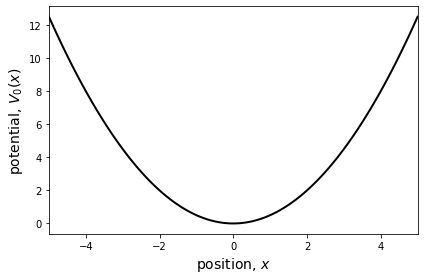

In [48]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, Vx, lw = 2, c = 'k')

ax.set_xlim(qho.x_left, qho.x_right)

ax.set_ylabel('potential, $V_0(x)$', fontsize = 14)
ax.set_xlabel('position, $x$', fontsize = 14)

fig.tight_layout()

This is fine.  It agrees with the equation presented, although it must be considered that this isn't realistic for any particle.  In the class, we assume $m = 1$ and $\omega = 1$ always, which is a bit strange for a quantum system.  Regardless, it is a good toy example.  

We can then introduce a perturbation to the potential such that
\begin{equation}
V_1(x) = V(x) + \dfrac{1}{40}m\omega^2 x^3
\end{equation}

where $\frac{1}{40}m\omega^2 x^3$ is a third-order perturbation.  In order to implement this in Python, we can implement a child class to `Schroedinger` such that:

In [49]:
class Cubic_QHO(Schroedinger):
    # It takes in Schroedinger to show that Schroedinger is the parent.
    
    # We override the V function and introduce the perturbation.
    def V(self, x):
        return 0.5 * self.m * self.omega**2 * (x**2 + 1/20 * x**3)

And demonstrating that:

In [50]:
cubic_qho = Cubic_QHO(x_left, x_right, N)

In [51]:
cubic_Vx = cubic_qho.V(x)

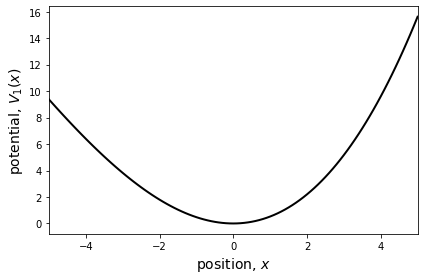

In [52]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, cubic_Vx, lw = 2, c = 'k')

ax.set_xlim(cubic_qho.x_left, cubic_qho.x_right)

ax.set_ylabel('potential, $V_1(x)$', fontsize = 14)
ax.set_xlabel('position, $x$', fontsize = 14)

fig.tight_layout()

We can see that this loses its symmetry and widens a bit.  This actually makes sense, since in general $x^3$ is not a symmetric function.  So, all is as expected to behave.  We can contrast this again by introducing a fourth-order perturbation such that

\begin{equation}
V_2(x) = V(x) + \dfrac{1}{40}m\omega^2 x^4
\end{equation}

which once again can be represented in Python:

In [53]:
class Quartic_QHO(Schroedinger):
    # It takes in Schroedinger to show that Schroedinger is the parent.
    
    # We override the V function and introduce the perturbation.
    def V(self, x):
        return 0.5 * self.m * self.omega**2 * (x**2 + 1/20 * x**4)

And demonstrating that:

In [54]:
quartic_qho = Quartic_QHO(x_left, x_right, N)

In [55]:
quartic_Vx = quartic_qho.V(x)

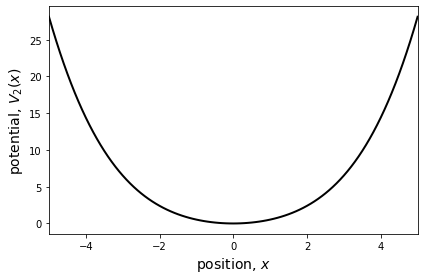

In [56]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, quartic_Vx, lw = 2, c = 'k')

ax.set_xlim(quartic_qho.x_left, quartic_qho.x_right)

ax.set_ylabel('potential, $V_2(x)$', fontsize = 14)
ax.set_xlabel('position, $x$', fontsize = 14)

fig.tight_layout()

As such, we can see that it regains its symmetry since it's an even function.  To further demonstrate this, we can plot them all on top of each other:

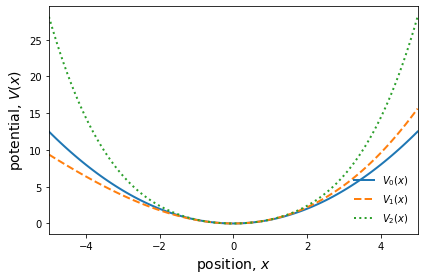

In [58]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, Vx, lw = 2, label = r'$V_0(x)$')
ax.plot(x, cubic_Vx, lw = 2, ls = '--', label = r'$V_1(x)$')
ax.plot(x, quartic_Vx, lw = 2, ls = ':', label = r'$V_2(x)$')

ax.set_xlim(quartic_qho.x_left, quartic_qho.x_right)

ax.set_ylabel('potential, $V(x)$', fontsize = 14)
ax.set_xlabel('position, $x$', fontsize = 14)

ax.legend(loc = 'lower right', fontsize = 10, frameon = False)

fig.tight_layout()

Really, if you subtract $V_0(x)$ from any of the perturbed potentials, what you'd find is the perturbation itself.  But this does not have to be shown, because it's simple mathematical calculation.  The graphs would not look all that different either, since the perturbations are a higher order term.  Nevertheless, we can move on to looking at how this affects eigenvalues:

**(B.)** _eigenvalues_

In order to understand how the perturbations are affecting the system, it is also important to look at the energy functions and their eigenvalues.  By fixing energy $E$ up to $E = 5$, we can get a general idea of how this looks:

In [63]:
# Set max energy:
E_max = 5

# Set starting point:
qho.E = 0.1

# Set step-size:
dE = 0.01

# Instead of the while loop ...
n_steps = int((E_max - qho.E)/dE)

qho_F = zeros((n_steps + 1))
cubic_F = qho_F.copy()
quartic_F = cubic_F.copy()

E = linspace(0.1, E_max, n_steps + 1)

E_data = []
F_data = []

for step in range(n_steps + 1):
    
    qho_F[step] = qho.F(E[step])
    cubic_F[step] = cubic_qho.F(E[step])
    quartic_F[step] = quartic_qho.F(E[step])

Like always, we can plot this:

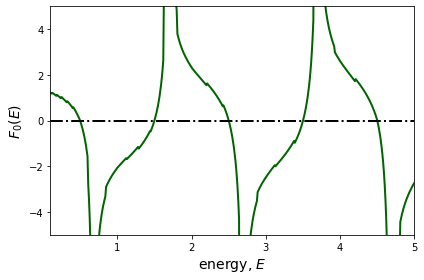

In [80]:
fig, ax = plt.subplots(1, 1)

ax.plot(E, qho_F, lw = 2, c = 'darkgreen')
ax.axhline(0, lw = 2, ls = 'dashdot', c = 'k')

ax.set_xlim(E[0], E[-1])
ax.set_ylim(-5, 5)

ax.set_ylabel('$F_0(E)$', fontsize = 14)
ax.set_xlabel('energy, $E$', fontsize = 14)

fig.tight_layout()

This is just a `tan(x)` like function, which is absolutely expected for the QHO.

The reason why this works is simply because $E$ is a combination of $V$ and the system's kinetic energy.  In the most basic case,

\begin{equation}
\hat{E}\psi = \lambda \psi
\end{equation}

where $\psi$ is the wave function and $\lambda$ is the eigenvalue.  More commonly, $E$ is denoted as $\hat{H}$, which is the Hamiltonian.  Either way, both are indicative of the total energy of the system.  

Furthermore, consider that $\lambda$ occurs at $F(E) = 0$ such that $\lambda = E|_{F(E) = 0}$.  Although we could derive a numerical algorithm to find these roots, since we are focusing on specific cases we can just do the following:

In [77]:
# Based on the graph, we know that there will be 5 roots.
qho_eigs = E[argsort(abs(qho_F))[:4]]
print(qho_eigs)

[0.5 1.5 2.5 3.5]


Once again, what we would predict!  Note that for a system like this, it is true that

\begin{equation}
\lambda_n = \hbar\omega \left(n + \frac{1}{2}\right)
\end{equation}

where $\hbar$ and $\omega$ are constants and $n$ is the number eigenvalue.  For this particular case, $\hbar = 1$ and $\omega = 1$, so if you calculate up until $n = 4$, then this agrees perfectly with our results.

Now, we can repeat for the perturbations.  This time, I will not plot them individually because the change will be most noticeable on an overlapped plot.

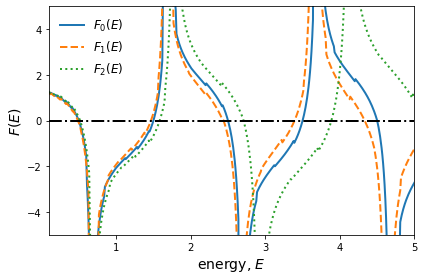

In [83]:
fig, ax = plt.subplots(1, 1)

ax.plot(E, qho_F, lw = 2, label = r'$F_0(E)$')
ax.plot(E, cubic_F, lw = 2, ls = '--', label = r'$F_1(E)$')
ax.plot(E, quartic_F, lw = 2, ls = ':', label = r'$F_2(E)$')


ax.axhline(0, lw = 2, ls = 'dashdot', c = 'k')

ax.set_xlim(qho_E[0], qho_E[-1])
ax.set_ylim(-5, 5)

ax.set_ylabel('$F(E)$', fontsize = 14)
ax.set_xlabel('energy, $E$', fontsize = 14)

ax.legend(loc = 'upper left', fontsize = 12, frameon = False)

fig.tight_layout()

We can see that the cubic perturbation scales the function to the left, whereas the quartic scales to the right.  This is not a shift, but rather an energy dependent multiplier.  This is evident by the gaps between each function growing as $E$ increases.

Although I do not know the precise formulation of the eigenvalues, they could be solved via the equation

\begin{equation}
\bar{E} = \bar{T} + \bar{V} = 2\bar{V}
\end{equation}

where $\bar{E}$ is the average energy.  Normally, this is with braket notation, but Jupyter does not have that library.  Otherwise, we typically treat $\bar{T} = \bar{V}$ where $T$ is the kinetic energy.  Perhaps with that, the eigenvalues could be more readily calculated.  Otherwise, their behavior on the function is apparent.

---